
# YOLOv2
> Darknet-19 + Passthrough(reorg) + Anchor 기반 YOLOv2 구현

**Pipeline**
1. 환경 체크 & 설정
2. 데이터셋 unzip → JSON 라벨 파싱 (bbox: x,y,w,h)
3. 클래스 자동 생성, 데이터 통계
4. K-means로 앵커(5개) 추정 (IoU distance)
5. YOLOv2 모델(Darknet-19 유사 + passthrough) 구현
6. 손실 함수(YOLOv2 스타일) 구현
7. 학습/검증 루프
8. 추론 및 시각화 (NMS 포함)


## 1) 환경 체크 & 기본 설정

In [ ]:
# (선택) GPU 체크
import torch, os, sys, math, random, json, zipfile, pathlib, time, shutil
import numpy as np
from PIL import Image, ImageDraw, ImageFont

print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

PyTorch: 2.6.0+cu124
CUDA available: True


device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2) 경로 설정 & 데이터셋 Unzip

In [ ]:
# pathlib 라이브러리에서 Path 객체 불러오기 (경로를 객체처럼 다룰 수 있음)
from pathlib import Path

# 탐색할 경로 리스트 (drawings.zip 이 있는 위치를 미리 지정)
zip_candidates = [Path("/content/drive/MyDrive/AI활용 소프트웨어 개발/13. 생성형 AI/data/drawings.zip")]

# 실제 사용할 zip 경로 변수 (아직 없음)
zip_path = None

# 존재하는 파일을 찾으면 zip_path에 할당
for c in zip_candidates:
    if c.exists():
        zip_path = c
        break

# zip_path를 못 찾으면 에러 발생
if zip_path is None:
    raise FileNotFoundError("drawings.zip 파일을 찾을 수 없습니다. 업로드 또는 경로 확인!")
print("Using zip:", zip_path)

# 압축 해제할 루트 폴더 지정 (./data)
root = Path("./data")

# 기존 폴더가 있으면 삭제 (재실행 대비)
if root.exists():
    print("기존 추출 폴더 삭제:", root)
    shutil.rmtree(root)

# data 폴더 새로 생성
root.mkdir(parents=True, exist_ok=True)

# zipfile 라이브러리로 압축 해제
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(root) # ./data 폴더에 압축 풀기

print("Extracted to:", root)

# 추출한 폴더 내부에서 "01.원천데이터" 폴더 찾기
src_dir = next(root.glob("**/01.원천데이터"))
# 추출한 폴더 내부에서 "02.라벨링데이터" 폴더 찾기
lbl_dir = next(root.glob("**/02.라벨링데이터"))

print("원천:", src_dir)
print("라벨:", lbl_dir)

# 이미지 확장자 모음 (이미지 필터링에 사용)
IMG_EXTS = {".jpg",".jpeg",".png",".bmp"}

Using zip: /content/drive/MyDrive/AI활용 소프트웨어 개발/13. 생성형 AI/data/drawings.zip
기존 추출 폴더 삭제: data
Extracted to: data
원천: data/Sample/01.원천데이터
라벨: data/Sample/02.라벨링데이터


## 3) 라벨 파싱: 클래스/박스 통계

In [ ]:
from collections import defaultdict, Counter
from PIL import Image

# JSON 라벨 파일을 파싱하는 함수
def parse_json(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        d = json.load(f) # JSON 로드
    meta = d.get("meta", {}) # 이미지 메타데이터 (경로, 해상도 등)
    ann = d.get("annotations", {}) # 어노테이션 정보
    bboxes = ann.get("bbox", []) # 바운딩박스 리스트 (x,y,w,h,label 포함)
    img_rel = meta.get("img_path") # 이미지 상대 경로
    # JSON 파일 위치 기준으로 실제 이미지 절대 경로 생성
    img_path = (Path(json_path).parent / Path(img_rel)).resolve()
    img_path = Path(str(img_path)).resolve()
    return {
        "img_path": img_path, # 이미지 실제 경로
        "bboxes": bboxes,  # [{x,y,w,h,label} ...]
        "img_resolution": meta.get("img_resolution",""), # 해상도 정보 (없으면 빈 문자열)
        "class": ann.get("class",""), # 전체 클래스 이름 (없으면 빈 문자열)
    }

# 이미지 크기를 (width, height) 형태로 반환
def image_size(path):
    try:
        with Image.open(path) as im:
            return im.size # (W, H)
    except Exception:
        return None # 이미지가 깨졌거나 없으면 None 반환

# 라벨 JSON 파일 리스트 수집
json_list = sorted([p for p in lbl_dir.rglob("*.json")])
print("라벨 파일 수:", len(json_list))

items = [] # 최종 이미지 + 어노테이션 모음
label_counter = Counter() # 라벨별 개수를 세기 위한 Counter

for jp in json_list:
    info = parse_json(jp) # JSON 파싱
    if not info["img_path"].exists(): # 이미지 파일이 실제로 없으면
        cand = list(src_dir.rglob(info["img_path"].name)) # 원천데이터에서 이름으로 재검색
        if cand:
            info["img_path"] = cand[0] # 발견 시 해당 경로로 교체
        else:
            continue # 이미지 못 찾으면 스킵
    # 바운딩박스 안의 라벨들을 세기
    for bb in info["bboxes"]:
        label_counter[bb.get("label","UNKNOWN")] += 1
    items.append(info) # 유효 데이터만 리스트에 추가

print("유효 이미지 수:", len(items))
print("라벨 분포 상위 20개:", label_counter.most_common(20))

# 클래스 인덱싱 (클래스명 <-> 숫자 ID 매핑)
classes = sorted(label_counter.keys()) # 전체 클래스 정렬
cls2idx = {c:i for i,c in enumerate(classes)} # 클래스명 → 인덱스
idx2cls = {i:c for c,i in cls2idx.items()} # 인덱스 → 클래스명
num_classes = len(classes)
print("총 클래스 수:", num_classes)
print("예시 클래스:", classes[:20])

# 앞 20장 이미지 크기 확인
sizes = []
for it in items[:20]:
    sizes.append(image_size(it["img_path"]))
print("앞 20장 크기 샘플:", sizes[:5])

라벨 파일 수: 560
유효 이미지 수: 560
라벨 분포 상위 20개: [('꽃', 637), ('눈', 560), ('팔', 560), ('발', 560), ('운동화', 560), ('다리', 559), ('귀', 557), ('손', 557), ('잔디', 525), ('주머니', 517), ('나뭇잎', 509), ('별', 485), ('열매', 477), ('단추', 290), ('사람전체', 280), ('머리', 280), ('얼굴', 280), ('코', 280), ('입', 280), ('머리카락', 280)]
총 클래스 수: 47
예시 클래스: ['가지', '구름', '굴뚝', '귀', '그네', '기둥', '길', '꽃', '나무', '나무전체', '나뭇잎', '남자구두', '눈', '다람쥐', '다리', '단추', '달', '머리', '머리카락', '목']
앞 20장 크기 샘플: [(1280, 1280), (1280, 1280), (1280, 1280), (1280, 1280), (1280, 1280)]


## 4) K-means로 Anchor 5개 추정

In [ ]:
import numpy as np

# YOLO 입력 이미지 크기 (416x416)
INPUT_SIZE = 416
# anchor 개수 (클러스터 개수)
K = 5

whs = [] # 바운딩박스의 (width, height) 비율 저장 리스트
for it in items:
    sz = image_size(it["img_path"]) # 이미지 크기 가져오기
    if sz is None:
        continue
    w_img, h_img = sz
    for bb in it["bboxes"]:
        # 바운딩박스의 w,h를 이미지 크기로 나누어 정규화 (0~1 범위)
        bw = bb["w"]/w_img
        bh = bb["h"]/h_img
        if bw>0 and bh>0: # 유효한 박스만 저장
            whs.append([bw,bh])
whs = np.array(whs, dtype=np.float32)
print("수집 박스 수:", len(whs))

# (w,h) 기반 IOU 계산 함수
def bbox_iou_wh(box, centers):
    w,h = box
    ww = centers[:,0]; hh=centers[:,1]
    inter = np.minimum(w,ww)*np.minimum(h,hh) # 교집합 면적
    union = w*h + ww*hh - inter + 1e-9 # 합집합 면적
    return inter/union # IOU 값 반환

# K-means 기반 anchor box 추출 함수
def kmeans_anchors(data, k=5, seed=42, iters=100):
    n = data.shape[0]
    np.random.seed(seed)
    # 초기 중심값 무작위 선택
    centers = data[np.random.choice(n, k, replace=False)].copy()
    for _ in range(iters):
        # --- assign 단계 ---
        assign = []
        for i in range(n):
            ious = bbox_iou_wh(data[i], centers) # 각 박스와 중심들의 IOU
            assign.append(int(np.argmax(ious))) # IOU가 가장 큰 중심에 할당
        assign = np.array(assign)

        # --- update 단계 ---
        new_centers = []
        for j in range(k):
            pts = data[assign==j] # 클러스터에 속한 박스들
            if len(pts)==0:
                # 비어있으면 임의의 박스를 다시 선택
                new_centers.append(data[np.random.randint(0,n)])
            else:
                # 중앙값(median)을 새 중심으로 업데이트
                new_centers.append(np.median(pts, axis=0))
        new_centers = np.array(new_centers)

        # 중심이 변하지 않으면 종료
        if np.allclose(centers, new_centers):
            break
        centers = new_centers
    return centers

# 실제로 anchor 추출 (데이터 충분하면 kmeans 실행)
if len(whs) >= K:
    anchors_wh = kmeans_anchors(whs, k=K)
else:
    # 데이터가 부족할 경우 기본 anchor 값 사용
    anchors_wh = np.array([[0.04,0.05],[0.1,0.12],[0.12,0.19],[0.23,0.12],[0.26,0.25]], dtype=np.float32)

# anchor 비율을 실제 입력 크기(416)로 변환
anchors_px = (anchors_wh * INPUT_SIZE).astype(np.float32)
print("Anchors (ratio):\n", anchors_wh) # 정규화된 비율
print("Anchors (px @416):\n", anchors_px) # 416 입력 크기 기준 px 단위


수집 박스 수: 13822
Anchors (ratio):
 [[0.02265625 0.02421875]
 [0.35546875 0.3265625 ]
 [0.07421875 0.07421875]
 [0.146875   0.159375  ]
 [0.04140625 0.04453125]]
Anchors (px @416):
 [[  9.425     10.075   ]
 [147.875    135.84999 ]
 [ 30.875     30.875   ]
 [ 61.1       66.299995]
 [ 17.225     18.525   ]]


## 5) 데이터셋 & 전처리

In [ ]:
import random
import numpy as np
from PIL import Image, ImageOps, ImageEnhance
import torch

# YOLO grid 설정
GRID_SIZE = 13
STRIDE = INPUT_SIZE // GRID_SIZE  # 416/13 = 32 → 하나의 grid cell 크기

# letterbox: 비율 유지한 resize 후 여백 채우기 (YOLO에서 자주 사용)
def letterbox(im: Image.Image, new_size=INPUT_SIZE, color=(114,114,114)):
    w,h = im.size
    scale = min(new_size/w, new_size/h) # 가로/세로 비율 중 작은 쪽에 맞춰 축소
    nw, nh = int(w*scale), int(h*scale) # 축소된 크기
    im_resized = im.resize((nw,nh), Image.BILINEAR)  # 축소
    canvas = Image.new('RGB', (new_size,new_size), color) # 빈 배경 생성
    pad_x = (new_size - nw)//2
    pad_y = (new_size - nh)//2
    canvas.paste(im_resized, (pad_x, pad_y)) # 중앙에 배치
    return canvas, scale, pad_x, pad_y

# 색상/밝기 증강 (HSV augmentation)
def augment_hsv(im: Image.Image, hgain=0.015, sgain=0.7, vgain=0.4):
    s_factor = 1 + (random.random()*2-1)*sgain
    v_factor = 1 + (random.random()*2-1)*vgain
    im = ImageEnhance.Color(im).enhance(s_factor) # 채도 변화
    im = ImageEnhance.Brightness(im).enhance(v_factor) # 밝기 변화
    return im

# 수평 반전 augmentation
def random_hflip(im: Image.Image, boxes):
    if random.random()<0.5:
        w,h = im.size
        im = ImageOps.mirror(im) # 좌우 반전
        nboxes = []
        for x,y,bw,bh,cls_id in boxes:
            nx = w - (x + bw) # 반전된 좌표 계산
            nboxes.append([nx,y,bw,bh,cls_id])
        return im, nboxes
    return im, boxes

# target tensor 빌드 (YOLO ground truth format)
def build_target_tensor(boxes, anchors, num_classes, grid_size=GRID_SIZE, img_size=INPUT_SIZE):
    target = np.zeros((grid_size, grid_size, anchors.shape[0], 5 + num_classes), dtype=np.float32)
    for (x,y,w,h,cls) in boxes:
        cx, cy = x + w/2, y + h/2 # 바운딩박스 중심 좌표
        gx, gy = int(cx//STRIDE), int(cy//STRIDE) # 해당 box가 속하는 grid cell
        if not(0 <= gx < grid_size and 0 <= gy < grid_size):
            continue
        gt = np.array([w,h], dtype=np.float32)

        # anchor 선택 (wh 기준 IOU 최대인 anchor)
        ious = []
        for a in anchors:
            inter = np.minimum(gt[0], a[0]) * np.minimum(gt[1], a[1])
            union = gt[0]*gt[1] + a[0]*a[1] - inter + 1e-9
            ious.append(inter/union)
        aidx = int(np.argmax(ious)) # 가장 IOU 큰 anchor 선택
        aw, ah = anchors[aidx]

        # 좌표 변환 (YOLO format)
        cx_cell = (cx/STRIDE) - gx
        cy_cell = (cy/STRIDE) - gy
        tx, ty = cx_cell, cy_cell
        tw = np.log((w/(aw+1e-9))+1e-9)
        th = np.log((h/(ah+1e-9))+1e-9)

        # target tensor 채우기
        target[gy,gx,aidx,0]=tx
        target[gy,gx,aidx,1]=ty
        target[gy,gx,aidx,2]=tw
        target[gy,gx,aidx,3]=th
        target[gy,gx,aidx,4]=1.0  # objectness
        target[gy,gx,aidx,5+cls]=1.0 # one-hot class
    return target

# --- Dataset 클래스 정의 ---
class DrawingsYOLODataset(torch.utils.data.Dataset):
    def __init__(self, items, cls2idx, input_size=INPUT_SIZE, anchors_px=None, augment=True):
        self.items = items
        self.cls2idx = cls2idx
        self.input_size = input_size
        self.anchors = np.array(anchors_px, dtype=np.float32)
        self.augment = augment
    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        info = self.items[idx]
        im = Image.open(info["img_path"]).convert("RGB") # 이미지 로드
        boxes = []
        # json에서 바운딩박스 읽기
        for bb in info["bboxes"]:
            x,y,w,h = bb["x"], bb["y"], bb["w"], bb["h"]
            cls_id = self.cls2idx.get(bb.get("label",""), -1)
            if cls_id<0 or w<=0 or h<=0: continue
            boxes.append([x,y,w,h,cls_id])
        # augmentation
        if self.augment:
            im, boxes = random_hflip(im, boxes)
            im = augment_hsv(im)
        # letterbox resize
        im_lb, scale, pad_x, pad_y = letterbox(im, self.input_size)
        # resize/패딩된 좌표로 보정
        nboxes = []
        for x,y,w,h,cls_id in boxes:
            x = x*scale + pad_x; y = y*scale + pad_y
            w = w*scale; h = h*scale
            nboxes.append([x,y,w,h,cls_id])
        # target tensor 생성
        target = build_target_tensor(nboxes, self.anchors, num_classes=len(self.cls2idx))
        # 이미지 → [C,H,W] tensor
        arr = np.array(im_lb).astype(np.float32)/255.0
        arr = np.transpose(arr,(2,0,1))
        img = torch.from_numpy(arr)
        tgt = torch.from_numpy(target)
        return img, tgt

# collate_fn: dataloader가 batch 구성할 때 사용
def collate_fn(b):
    imgs = torch.stack([x[0] for x in b])
    tgts = torch.stack([x[1] for x in b])
    return imgs, tgts

# --- 데이터 분할 ---
random.seed(42)
perm = list(range(len(items)))
random.shuffle(perm)
n_train = int(len(perm)*0.9)  # 90% train, 10% val
train_idx, val_idx = perm[:n_train], perm[n_train:]
train_items = [items[i] for i in train_idx]
val_items = [items[i] for i in val_idx]

# Dataset 생성
train_ds = DrawingsYOLODataset(train_items, cls2idx, INPUT_SIZE, anchors_px, augment=True)
val_ds   = DrawingsYOLODataset(val_items, cls2idx, INPUT_SIZE, anchors_px, augment=False)

# DataLoader 생성
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

# 데이터셋 크기 확인
len(train_ds), len(val_ds)


(504, 56)

## 6) YOLOv2 모델 (Darknet-19 유사 + Passthrough)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Conv → BN → LeakyReLU 블록 (YOLO에서 반복적으로 사용)
def conv_bn_leaky(c_in, c_out, k=3, s=1, p=None):
    if p is None: p = (k-1)//2 # 기본 padding: same
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, k, s, p, bias=False), # Conv
        nn.BatchNorm2d(c_out), # BatchNorm
        nn.LeakyReLU(0.1, inplace=True) # LeakyReLU(0.1)
    )

# YOLOv2의 Backbone: Darknet-19
class Darknet19(nn.Module):
    # 416x416 입력 → 13x13 feature
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            conv_bn_leaky(3,32,3,1),
            nn.MaxPool2d(2,2),  # 416 → 208
        )
        self.layer2 = nn.Sequential(
            conv_bn_leaky(32,64,3,1),
            nn.MaxPool2d(2,2),  # 208 → 104
        )
        self.layer3 = nn.Sequential(
            conv_bn_leaky(64,128,3,1),
            conv_bn_leaky(128,64,1,1),
            conv_bn_leaky(64,128,3,1),
            nn.MaxPool2d(2,2),  # 104 → 52
        )
        self.layer4 = nn.Sequential(
            conv_bn_leaky(128,256,3,1),
            conv_bn_leaky(256,128,1,1),
            conv_bn_leaky(128,256,3,1),
            nn.MaxPool2d(2,2),   # 52 → 26
        )
        self.layer5 = nn.Sequential(
            conv_bn_leaky(256,512,3,1),
            conv_bn_leaky(512,256,1,1),
            conv_bn_leaky(256,512,3,1),
            conv_bn_leaky(512,256,1,1),
            conv_bn_leaky(256,512,3,1),
        )  # 26x26 feature map
        self.maxpool5 = nn.MaxPool2d(2,2) # 26 → 13
        self.layer6 = nn.Sequential(
            conv_bn_leaky(512,1024,3,1),
            conv_bn_leaky(1024,512,1,1),
            conv_bn_leaky(512,1024,3,1),
            conv_bn_leaky(1024,512,1,1),
            conv_bn_leaky(512,1024,3,1),
        )  # 최종 13x13 feature map

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        route = self.layer5(x)    # 26x26 feature (passthrough 용)
        x = self.maxpool5(route)  # 13x13
        x = self.layer6(x)        # 13x13
        return route, x # (26x26, 13x13) 둘 다 반환

# Reorg Layer (YOLOv2 passthrough connection)
# stride=2 → 26x26 feature → 13x13로 줄이면서 채널 수 4배 증가
class Reorg(nn.Module):
    def __init__(self, stride=2):
        super().__init__()
        self.stride = stride
    def forward(self, x):
        B,C,H,W = x.shape
        s = self.stride
        assert H%s==0 and W%s==0
        # (B, C, H//s, s, W//s, s) → (B, C*s*s, H//s, W//s)
        x = x.view(B, C, H//s, s, W//s, s).permute(0,1,3,5,2,4).contiguous()
        x = x.view(B, C*s*s, H//s, W//s)
        return x

# YOLOv2 Head
class YOLOv2(nn.Module):
    def __init__(self, num_classes, anchors, grid_size=13):
        super().__init__()
        self.num_classes = num_classes
        self.K = anchors.shape[0] # anchor 개수
        self.S = grid_size  # grid 크기
        self.anchors = torch.tensor(anchors, dtype=torch.float32) # anchor 리스트
        self.backbone = Darknet19() # feature extractor (Darknet19)
        self.passthrough_conv = conv_bn_leaky(512,64,1,1,0) # 26x26 → 채널 축소
        self.reorg = Reorg(2) # 26x26 → 13x13, 채널 4배
        self.head = nn.Sequential(
            conv_bn_leaky(1024 + 64*4, 1024, 3,1), # concat 후 conv
            nn.Conv2d(1024, self.K*(5+num_classes), 1,1,0) # 최종 예측
        )
    def forward(self, x):
        route26, x13 = self.backbone(x) # backbone 출력
        p = self.passthrough_conv(route26) # 26x26 conv
        p = self.reorg(p) # 26x26 → 13x13 (채널 증가)
        x = torch.cat([x13, p], dim=1) # skip connection concat
        out = self.head(x)  # (B, K*(5+C), 13, 13)
        B,C,H,W = out.shape
        # (B, 13, 13, K, 5+C) 로 reshape
        out = out.permute(0,2,3,1).contiguous().view(B, H, W, self.K, 5+self.num_classes)
        return out


## 7) 손실 함수

In [ ]:
import torch.nn.functional as F

class YOLOv2Loss(nn.Module):
    def __init__(self, anchors, num_classes, lambda_coord=5.0, lambda_noobj=0.5):
        super().__init__()
        # anchor box 크기 (px 단위)
        self.anchors = torch.tensor(anchors, dtype=torch.float32)
        self.num_classes = num_classes
        # 논문에서 사용된 손실 가중치
        self.lambda_coord = lambda_coord # 좌표 손실 가중치 (기본 5)
        self.lambda_noobj = lambda_noobj # noobj 손실 가중치 (기본 0.5)

    def forward(self, pred, target):
        """
        pred   : (B, S, S, K, 5+C) 모델 출력 (raw 값)
        target : (B, S, S, K, 5+C) 정답 텐서
                 (tx,ty,tw,th, obj, one-hot class)
        """
        device = pred.device

        # --- 모델 예측값 ---
        p_tx, p_ty = pred[...,0], pred[...,1] # 중심 좌표 오프셋 (tx, ty)
        p_tw, p_th = pred[...,2], pred[...,3] # 너비/높이 로그 스케일 (tw, th)
        p_to = pred[...,4] # objectness score (confidence)
        p_cls = pred[...,5:]  # 클래스 확률 (logits)

        # --- 타겟값 ---
        t_tx, t_ty = target[...,0], target[...,1]
        t_tw, t_th = target[...,2], target[...,3]
        t_to = target[...,4]  # object mask (1=obj, 0=noobj)
        t_cls = target[...,5:] # one-hot 클래스 벡터

        # 마스크
        obj = t_to # 객체가 있는 셀
        noobj = 1.0 - obj # 객체가 없는 셀

        # --- 1. 좌표 손실 (λ_coord * MSE) ---
        # 객체가 있는 위치(obj)에서만 계산
        l_tx = F.mse_loss(p_tx*obj, t_tx*obj, reduction='sum')
        l_ty = F.mse_loss(p_ty*obj, t_ty*obj, reduction='sum')
        l_tw = F.mse_loss(p_tw*obj, t_tw*obj, reduction='sum')
        l_th = F.mse_loss(p_th*obj, t_th*obj, reduction='sum')
        l_coord = l_tx + l_ty + l_tw + l_th

        # --- 2. confidence (objectness) 손실 ---
        # 객체가 있는 위치 → 1.0, 없는 위치 → 0.0
        # BCE with logits 사용
        l_obj   = F.binary_cross_entropy_with_logits(p_to[obj.bool()], torch.ones_like(p_to[obj.bool()]), reduction='sum') if obj.bool().any() else torch.tensor(0.0, device=device)
        l_noobj = F.binary_cross_entropy_with_logits(p_to[noobj.bool()], torch.zeros_like(p_to[noobj.bool()]), reduction='sum') if noobj.bool().any() else torch.tensor(0.0, device=device)
        l_conf = l_obj + self.lambda_noobj*l_noobj

        # --- 3. 클래스 손실 (CrossEntropy) ---
        # 객체가 있는 위치(obj)에 대해서만 계산
        if self.num_classes>1 and obj.bool().any():
            # one-hot → index 변환
            t_idx = torch.argmax(t_cls[obj.bool()], dim=-1)
            l_cls = F.cross_entropy(p_cls[obj.bool()], t_idx, reduction='sum')
        else:
            l_cls = torch.tensor(0.0, device=device)

        # --- 최종 손실 ---
        # 논문 수식: λ_coord * coord_loss + conf_loss + class_loss
        loss = self.lambda_coord*l_coord + l_conf + l_cls

        # 학습 로그용 컴포넌트 딕셔너리
        comp = {"coord": l_coord.detach().item(), "conf": l_conf.detach().item(), "class": l_cls.detach().item()}

        # 배치 크기로 normalize 후 반환
        return loss/pred.shape[0], comp


## 8) 학습 / 검증

In [ ]:
from tqdm import tqdm

# 모델/손실/최적화기 정의
model = YOLOv2(num_classes=num_classes, anchors=anchors_px, grid_size=GRID_SIZE).to(DEVICE)
criterion = YOLOv2Loss(anchors=anchors_px, num_classes=num_classes).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4) # 학습률, SGD + momentum, L2 정규화

# --- 1. 학습 루프 ---
def train_one_epoch(model, loader, optimizer):
    model.train() # 학습 모드
    total = 0.0
    pbar = tqdm(loader, desc="train") # 진행률 바
    for imgs, tgts in pbar:
        # 데이터를 GPU/CPU로 이동
        imgs = imgs.to(DEVICE, non_blocking=True).float()
        tgts = tgts.to(DEVICE, non_blocking=True).float()

        # 순전파
        preds = model(imgs)
        loss, comp = criterion(preds, tgts)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0) # gradient clipping
        optimizer.step()

        # 손실 누적 및 표시
        total += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.3f}", "coord": f"{comp['coord']:.1f}", "conf": f"{comp['conf']:.1f}", "class": f"{comp['class']:.1f}"})
    return total/len(loader) # 평균 손실 반환

# --- 2. 검증 루프 ---
@torch.no_grad()
def validate(model, loader):
    model.eval() # 평가 모드
    total = 0.0
    for imgs, tgts in loader:
        imgs = imgs.to(DEVICE, non_blocking=True).float()
        tgts = tgts.to(DEVICE, non_blocking=True).float()
        preds = model(imgs)
        loss, comp = criterion(preds, tgts)
        total += loss.item()
    return total/len(loader) # 평균 손실 반환

# --- 3. 전체 학습 반복 ---
EPOCHS = 50
best = 1e9 # 최적 검증 손실 초기값
for ep in range(1, EPOCHS+1):
    tl = train_one_epoch(model, train_loader, optimizer) # train loss
    vl = validate(model, val_loader)  # val loss
    print(f"[{ep:03d}] train={tl:.4f}  val={vl:.4f}")

    # 베스트 모델 저장
    if vl < best:
        best = vl
        torch.save({"model":model.state_dict(), "anchors":anchors_px, "classes":classes}, "yolov2_drawings_best.pt")
        print("  ↳ Best model saved.")


train: 100%|██████████| 63/63 [00:30<00:00,  2.07it/s, loss=330.358, coord=155.0, conf=1232.3, class=635.5]


[001] train=463.3362  val=330.3753
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s, loss=277.865, coord=147.9, conf=783.4, class=699.8]


[002] train=302.0047  val=272.2680
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:34<00:00,  1.80it/s, loss=224.025, coord=99.5, conf=633.7, class=661.1]


[003] train=247.9372  val=242.0277
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  2.00it/s, loss=237.443, coord=100.5, conf=653.4, class=743.5]


[004] train=221.7300  val=214.6300
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:29<00:00,  2.10it/s, loss=181.458, coord=67.4, conf=504.1, class=610.4]


[005] train=203.1161  val=200.6525
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  2.01it/s, loss=171.475, coord=62.3, conf=472.9, class=587.4]


[006] train=189.7648  val=187.6991
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:29<00:00,  2.11it/s, loss=184.218, coord=64.6, conf=516.2, class=634.7]


[007] train=178.2397  val=176.6163
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  1.98it/s, loss=139.045, coord=50.2, conf=403.0, class=458.3]


[008] train=168.0401  val=168.3730
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:29<00:00,  2.11it/s, loss=183.269, coord=63.7, conf=531.1, class=616.6]


[009] train=158.6910  val=168.5006


train: 100%|██████████| 63/63 [00:31<00:00,  2.02it/s, loss=162.030, coord=50.3, conf=508.0, class=536.6]


[010] train=149.7756  val=152.8159
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, loss=150.091, coord=54.8, conf=440.0, class=486.6]


[011] train=142.7244  val=148.6325
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.06it/s, loss=137.394, coord=45.2, conf=414.9, class=458.3]


[012] train=136.6387  val=151.5467


train: 100%|██████████| 63/63 [00:30<00:00,  2.05it/s, loss=127.278, coord=47.0, conf=392.7, class=390.7]


[013] train=131.4501  val=140.0447
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:29<00:00,  2.10it/s, loss=130.629, coord=45.4, conf=419.7, class=398.3]


[014] train=125.8128  val=137.4961
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  2.01it/s, loss=126.554, coord=35.3, conf=447.0, class=389.0]


[015] train=121.1464  val=134.1746
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s, loss=111.455, coord=37.1, conf=359.7, class=346.2]


[016] train=115.7938  val=131.0831
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  2.01it/s, loss=113.893, coord=33.9, conf=363.6, class=377.8]


[017] train=113.2318  val=152.5747


train: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s, loss=100.286, coord=29.8, conf=335.6, class=317.7]


[018] train=108.1440  val=125.8293
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  2.02it/s, loss=108.541, coord=40.6, conf=379.7, class=285.8]


[019] train=104.5748  val=125.0250
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s, loss=141.632, coord=30.3, conf=487.2, class=494.3]


[020] train=101.3854  val=127.4055


train: 100%|██████████| 63/63 [00:30<00:00,  2.10it/s, loss=122.592, coord=27.5, conf=446.6, class=396.6]


[021] train=98.5229  val=123.1998
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  2.02it/s, loss=96.904, coord=22.5, conf=365.9, class=296.7]


[022] train=95.3646  val=118.4209
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.10it/s, loss=90.559, coord=21.1, conf=324.2, class=295.0]


[023] train=91.8315  val=119.2062


train: 100%|██████████| 63/63 [00:30<00:00,  2.05it/s, loss=85.254, coord=18.1, conf=334.7, class=257.1]


[024] train=89.8973  val=155.3018


train: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s, loss=81.595, coord=19.4, conf=304.9, class=250.8]


[025] train=86.7737  val=115.9477
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  2.01it/s, loss=85.371, coord=21.5, conf=332.1, class=243.2]


[026] train=84.3435  val=142.9157


train: 100%|██████████| 63/63 [00:30<00:00,  2.07it/s, loss=76.006, coord=17.1, conf=334.5, class=187.9]


[027] train=81.3800  val=113.0838
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  2.01it/s, loss=78.939, coord=18.3, conf=301.5, class=238.5]


[028] train=79.5696  val=112.9536
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:29<00:00,  2.11it/s, loss=68.827, coord=14.9, conf=251.2, class=224.9]


[029] train=76.5478  val=121.6435


train: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, loss=66.971, coord=15.1, conf=265.4, class=195.0]


[030] train=74.7839  val=111.9741
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  2.01it/s, loss=71.293, coord=14.0, conf=277.7, class=222.7]


[031] train=72.3055  val=131.0719


train: 100%|██████████| 63/63 [00:28<00:00,  2.17it/s, loss=62.797, coord=13.0, conf=273.9, class=163.3]


[032] train=70.7008  val=146.9868


train: 100%|██████████| 63/63 [00:31<00:00,  2.03it/s, loss=74.624, coord=13.8, conf=287.1, class=240.9]


[033] train=67.8617  val=112.0974


train: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s, loss=72.637, coord=16.9, conf=286.5, class=210.1]


[034] train=66.8154  val=108.8436
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  2.01it/s, loss=64.911, coord=13.1, conf=265.4, class=188.3]


[035] train=64.1131  val=111.7991


train: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s, loss=55.678, coord=10.5, conf=221.9, class=170.9]


[036] train=62.6291  val=107.0818
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s, loss=48.067, coord=8.9, conf=206.6, class=133.3]


[037] train=60.9482  val=158.1156


train: 100%|██████████| 63/63 [00:30<00:00,  2.05it/s, loss=61.585, coord=13.9, conf=254.0, class=169.3]


[038] train=59.1594  val=128.0684


train: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s, loss=56.862, coord=8.8, conf=231.5, class=179.3]


[039] train=56.5129  val=105.4588
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.07it/s, loss=46.519, coord=8.9, conf=205.8, class=121.8]


[040] train=54.5440  val=117.9485


train: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, loss=51.226, coord=10.2, conf=200.0, class=158.6]


[041] train=52.9992  val=104.7366
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.04it/s, loss=51.773, coord=10.8, conf=229.5, class=130.8]


[042] train=51.1842  val=108.4898


train: 100%|██████████| 63/63 [00:29<00:00,  2.11it/s, loss=47.413, coord=9.1, conf=190.3, class=143.3]


[043] train=49.9999  val=126.0164


train: 100%|██████████| 63/63 [00:30<00:00,  2.04it/s, loss=45.288, coord=9.6, conf=195.6, class=118.6]


[044] train=47.2860  val=108.3018


train: 100%|██████████| 63/63 [00:31<00:00,  2.02it/s, loss=48.593, coord=10.4, conf=186.4, class=150.6]


[045] train=46.5528  val=110.8974


train: 100%|██████████| 63/63 [00:29<00:00,  2.11it/s, loss=45.987, coord=7.7, conf=169.3, class=160.3]


[046] train=43.8331  val=138.5779


train: 100%|██████████| 63/63 [00:31<00:00,  2.00it/s, loss=46.371, coord=9.3, conf=184.8, class=139.5]


[047] train=42.4442  val=109.3279


train: 100%|██████████| 63/63 [00:30<00:00,  2.10it/s, loss=39.746, coord=9.6, conf=169.8, class=100.4]


[048] train=40.8942  val=170.1040


train: 100%|██████████| 63/63 [00:31<00:00,  1.99it/s, loss=38.449, coord=8.4, conf=141.1, class=124.3]


[049] train=39.2292  val=107.9497


train: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s, loss=33.699, coord=7.5, conf=114.0, class=118.3]


[050] train=37.8221  val=133.6708


In [ ]:
# 1. Noto CJK (중국어, 일본어, 한국어) 폰트 설치
#    - Google에서 배포하는 CJK 전용 폰트 패키지
!apt-get -y install fonts-noto-cjk
# 2. 폰트 캐시 갱신
#    - 새로 설치한 폰트를 시스템에 반영하기 위해 실행
!fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 3s (18.6 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126380 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fon

## 9) 추론 디코딩 + NMS + 시각화

In [ ]:
import numpy as np, math, torch
from PIL import Image, ImageDraw, ImageFont

# 시그모이드 (numpy 버전)
def sigmoid_np(x):
    return 1/(1+np.exp(-x))

# (cx,cy,w,h) → (x1,y1,x2,y2) 변환
def xywh_to_xyxy(box):
    cx,cy,w,h = box
    return [cx-w/2, cy-h/2, cx+w/2, cy+h/2]

# 두 박스(xyxy)의 IoU 계산
def iou_xyxy(a,b):
    ax1,ay1,ax2,ay2 = a
    bx1,by1,bx2,by2 = b
    inter_x1 = max(ax1,bx1); inter_y1=max(ay1,by1)
    inter_x2 = min(ax2,bx2); inter_y2=min(ay2,by2)
    inter_w = max(0.0, inter_x2-inter_x1); inter_h=max(0.0, inter_y2-inter_y1)
    inter = inter_w*inter_h
    area_a = (ax2-ax1)*(ay2-ay1); area_b=(bx2-bx1)*(by2-by1)
    union = area_a + area_b - inter + 1e-9
    return inter/union

# 클래스별 NMS (scores 내림차순 정렬 → IoU 임계 초과 항목 제거)
def nms(boxes, scores, iou_th=0.5):
    idxs = np.argsort(-scores)
    keep=[]
    while len(idxs)>0:
        i = idxs[0]; keep.append(i)
        if len(idxs)==1: break
        rest = idxs[1:]
        ious = np.array([iou_xyxy(boxes[i], boxes[j]) for j in rest])
        idxs = rest[ious < iou_th]
    return keep

# ---------- 한글 폰트 & 가독성 좋은 드로잉 ----------
def _get_font(size=16):
    paths = [
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",  # Colab 권장
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.otf",
        "/Library/Fonts/AppleGothic.ttf",
        "C:/Windows/Fonts/malgun.ttf",
    ]
    for p in paths:
        try:
            return ImageFont.truetype(p, size)
        except Exception:
            continue
    return ImageFont.load_default() # 최후의 수단

def _draw_boxes_pretty(img_pil, boxes, scores, labels, idx2cls,
                       base_thickness=2, base_font=16, pad=3):
    """
    - 박스는 두 겹 테두리(검정→초록)로 시인성↑
    - 라벨 배경은 흰색 박스 + 검정 테두리 + 검정 글씨
    - 해상도에 따라 선굵기/폰트 자동 스케일링
    """
    W, H = img_pil.size
    scale = max(W, H) / 512.0
    th = max(2, int(base_thickness * scale))
    font = _get_font(max(12, int(base_font * scale)))
    draw = ImageDraw.Draw(img_pil)

    for (x1, y1, x2, y2), s, c in zip(boxes, scores, labels):
        # 두 겹 테두리(검정 -> 초록)
        draw.rectangle([x1, y1, x2, y2], outline=(0, 0, 0), width=th+2)
        draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=th)

        # 라벨 텍스트 크기 계산
        text = f"{idx2cls[c]} {s:.2f}"
        tx1, ty1, tx2, ty2 = draw.textbbox((0, 0), text, font=font)
        tw, th_text = tx2 - tx1, ty2 - ty1

        # 박스 위에 공간이 없으면 박스 내부(아래쪽)에 표시
        bx1 = max(0, int(x1))
        by1 = int(y1 - th_text - 2*pad)
        if by1 < 0:
            by1 = int(y1)
        bx2 = min(W, bx1 + tw + 2*pad)
        by2 = min(H, by1 + th_text + 2*pad)

        # 라벨 배경(흰색) + 테두리(검정) + 글씨(검정)
        draw.rectangle([bx1, by1, bx2, by2], fill=(255, 255, 255))
        draw.rectangle([bx1, by1, bx2, by2], outline=(0, 0, 0), width=1)
        draw.text((bx1 + pad, by1 + pad), text, fill=(0, 0, 0), font=font)
    return img_pil
# ---------------------------------------------------

@torch.no_grad()
def infer_image(model, img_path, conf_th=0.25, iou_th=0.5):
    """
    단일 이미지 추론 + 디코딩 + 클래스별 NMS + 시각화까지 수행.
    필요 전역: INPUT_SIZE, GRID_SIZE, STRIDE, anchors_px, DEVICE, idx2cls, letterbox
    반환: (시각화된 PIL.Image, (final_boxes, final_scores, final_labels))
    """
    # 1) 이미지 로드 & letterbox
    im = Image.open(img_path).convert("RGB")
    im_lb, scale, pad_x, pad_y = letterbox(im, INPUT_SIZE) # 416x416 캔버스
    arr = np.array(im_lb).astype(np.float32)/255.0
    arr = np.transpose(arr,(2,0,1))
    t = torch.from_numpy(arr).unsqueeze(0).to(DEVICE)

    # 2) 모델 추론
    pred = model(t)[0].cpu().numpy()  # (S,S,K,5+C)

    boxes_all=[]; scores_all=[]; labels_all=[]
    # 3) 그리드/앵커별 디코딩 & confidence 필터링
    for gy in range(GRID_SIZE):
        for gx in range(GRID_SIZE):
            for a in range(anchors_px.shape[0]):
                tx,ty,tw,th,to = pred[gy,gx,a,:5]
                cls_logits = pred[gy,gx,a,5:]

                # objectness(sigmoid)와 class softmax를 곱해 최종 신뢰도
                obj = sigmoid_np(to)
                exp_logits = np.exp(cls_logits - cls_logits.max())
                cls_prob = exp_logits/exp_logits.sum()
                cidx = int(cls_prob.argmax())
                conf = obj * cls_prob[cidx]
                if conf < conf_th:
                    continue

                # YOLOv2 좌표 디코딩:
                # cx,cy: 셀 내부 오프셋(sigmoid) + 셀 좌표 → 픽셀 단위로 복원
                cx = (sigmoid_np(tx) + gx) * STRIDE
                cy = (sigmoid_np(ty) + gy) * STRIDE
                # w,h: anchor * exp(tw,th)
                aw,ah = anchors_px[a]
                bw = aw * math.exp(tw)
                bh = ah * math.exp(th)
                # xyxy 변환
                x1,y1,x2,y2 = xywh_to_xyxy([cx,cy,bw,bh])

                boxes_all.append([x1,y1,x2,y2]); scores_all.append(float(conf)); labels_all.append(cidx)

    # 감지 없음 → 원본(letterboxed) 이미지 반환
    if len(boxes_all)==0:
        return im_lb, ([],[],[])

    boxes_all = np.array(boxes_all, dtype=np.float32)
    scores_all = np.array(scores_all, dtype=np.float32)
    labels_all = np.array(labels_all, dtype=np.int32)

    # 4) 클래스별 NMS
    final_boxes, final_scores, final_labels = [], [], []
    for c in np.unique(labels_all):
        idxs = np.where(labels_all==c)[0]
        if len(idxs)==0: continue
        keep = nms(boxes_all[idxs], scores_all[idxs], iou_th)
        for k in keep:
            final_boxes.append(boxes_all[idxs][k].tolist())
            final_scores.append(float(scores_all[idxs][k]))
            final_labels.append(int(c))

    # 5) 한글 폰트 + 고가독 라벨로 그리기
    draw = im_lb.copy()
    draw = _draw_boxes_pretty(draw, final_boxes, final_scores, final_labels, idx2cls)
    return draw, (final_boxes, final_scores, final_labels)

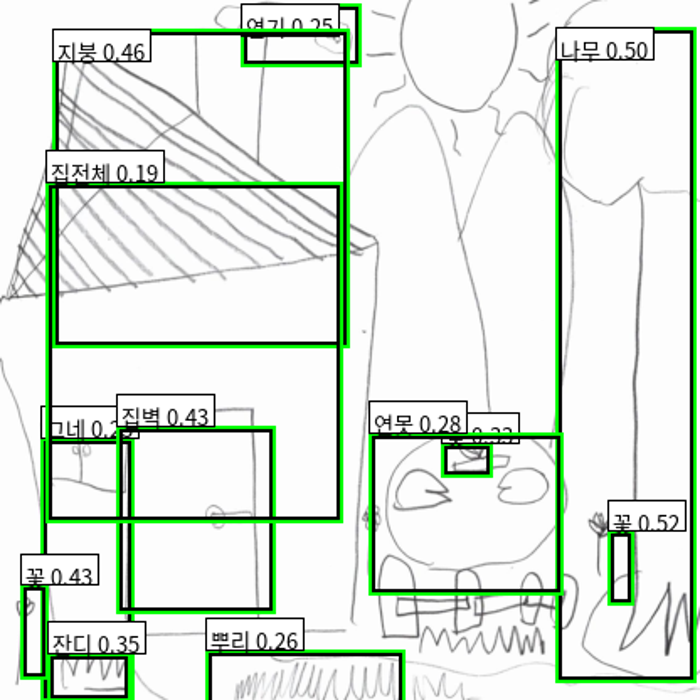

클래스: 그네, 점수: 0.228, 박스좌표: [24.123220443725586, 260.3638610839844, 79.96733856201172, 416.5488586425781]
클래스: 꽃, 점수: 0.516, 박스좌표: [361.116455078125, 315.0379943847656, 376.8060302734375, 359.3063659667969]
클래스: 꽃, 점수: 0.434, 박스좌표: [12.267096519470215, 347.14910888671875, 28.304813385009766, 403.0576171875]
클래스: 꽃, 점수: 0.331, 박스좌표: [262.27252197265625, 263.9309387207031, 292.29315185546875, 283.9320373535156]
클래스: 나무, 점수: 0.499, 박스좌표: [330.12640380859375, 16.184494018554688, 413.48919677734375, 405.74322509765625]
클래스: 뿌리, 점수: 0.263, 박스좌표: [122.00347900390625, 386.3583984375, 240.54074096679688, 425.35577392578125]
클래스: 연기, 점수: 0.251, 박스좌표: [143.59243774414062, 2.1813621520996094, 214.921875, 39.71669006347656]
클래스: 연못, 점수: 0.281, 박스좌표: [219.58778381347656, 257.8212890625, 334.0015869140625, 353.91473388671875]
클래스: 잔디, 점수: 0.347, 박스좌표: [28.81120491027832, 388.4072570800781, 77.08967590332031, 416.2849426269531]
클래스: 지붕, 점수: 0.462, 박스좌표: [31.921897888183594, 17.056655883789062, 207.37414

In [ ]:
# 샘플 이미지 경로 (train_items, val_items 같은 리스트에서 하나 뽑아오기)
sample_img = train_items[0]["img_path"]   # dataset 로딩 코드에서 만든 train_items 사용

# 추론 및 시각화
drawn, (boxes, scores, labels) = infer_image(
    model,
    sample_img,
    conf_th=0.15,   # 낮추면 더 많은 박스 출력
    iou_th=0.45
)

# 화면에 크게 표시
drawn_resized = drawn.resize((700, 700))
display(drawn_resized)

# 박스/라벨 결과도 출력
for b, s, l in zip(boxes, scores, labels):
    print(f"클래스: {idx2cls[l]}, 점수: {s:.3f}, 박스좌표: {b}")

## 10) 배치 추론 & 저장

In [ ]:
from pathlib import Path
# 결과 저장할 폴더 생성
out_dir = Path("./predictions_yolov2"); out_dir.mkdir(parents=True, exist_ok=True)

# 검증 데이터(val_items) 중 30장만 추론해서 저장
for it in val_items[:30]:
    img_p = it["img_path"] # 원본 이미지 경로
    drawn, _ = infer_image(model, img_p, conf_th=0.25, iou_th=0.45)  # YOLOv2 추론 + 시각화
    save_p = out_dir / (Path(img_p).stem + "_pred.jpg") # 저장 경로 지정
    drawn.save(save_p) # 결과 이미지 저장

print("Saved to:", out_dir.resolve()) # 저장 폴더 경로 출력

Saved to: /content/predictions_yolov2
